In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [106]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Daily_Minimum_Temperatures.csv')
df.head()

,Date,Temp
0,01-01-1981,20.7
1,02-01-1981,17.9
2,03-01-1981,18.8
3,04-01-1981,14.6
4,05-01-1981,15.8


In [107]:
df.tail()

,Date,Temp
2915,26-12-1988,9.5
2916,27-12-1988,12.9
2917,28-12-1988,12.9
2918,29-12-1988,14.8
2919,30-12-1988,14.1


In [10]:
df.shape

(2920, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2920 non-null   object 
 1   Temp    2920 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ KB


In [108]:
time = pd.date_range(start='1/1/1981',periods=2920,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [13]:
df.min()

Temp    0.0
dtype: float64

In [109]:
df = df + 1

In [16]:
plt.rcParams['figure.figsize'] = [15,8]

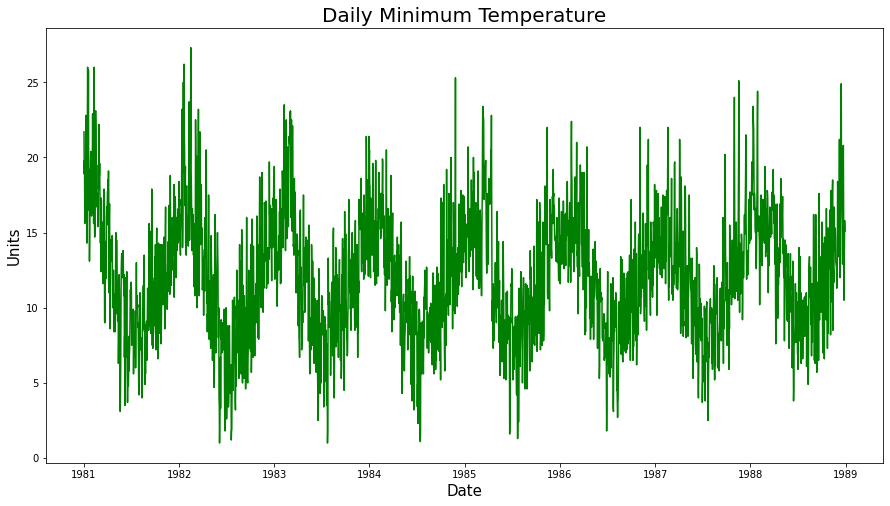

In [17]:
plt.plot(df,color='green')
plt.title('Daily Minimum Temperature',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [110]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [111]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Temp'] = df['Temp'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [112]:
#Split data set into testing dataset and train dataset
train_size = 2628
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 12
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [21]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2616, 12)
(2616,)
(280, 12)
(280,)


In [23]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [24]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [25]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 128,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [28]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 46s]
val_mape: 14.95457935333252

Best val_mape So Far: 14.95457935333252
Total elapsed time: 00h 11m 24s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 80
dropout: True
learning_rate: 0.0019466483330733626
Dropout_rate: 0.1
units_1: 120
units_2: 112
units_3: 56
units_4: 96
Score: 14.95457935333252
Trial summary
Hyperparameters:
num_layers: 3
units_0: 104
dropout: False
learning_rate: 0.0015377893817187592
Dropout_rate: 0.1
units_1: 48
units_2: 16
units_3: 8
units_4: 128
Score: 14.978797912597656
Trial summary
Hyperparameters:
num_layers: 5
units_0: 56
dropout: True
learning_rate: 0.021870957694520653
Dropout_rate: 0.0
units_1: 8
units_2: 8
units_3: 8
units_4: 8
Score: 14.993188858032227
Trial summary
Hyperparameters:
num_layers: 3
units_0: 120
dropout: True
learning_rate: 0.0007627145633271186
Dropout_rate: 0.4
units_1: 56
units_2: 16
units_3: 72
units_4: 8
Score: 15.078988075256348
Trial summary
Hyperparameters:
num_layers: 3
units_0: 16
dropout: False
learning_rate: 0.01

In [30]:
from warnings import filterwarnings
filterwarnings('ignore')

In [32]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                1040      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 120)               9720      
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [114]:
model = Sequential()
model.add(Dense(64,activation='relu',input_dim = 12))
model.add(Dropout(0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate= 0.00001466483330733626)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 300,callbacks=[EarlyStopping(monitor='val_loss', patience=40)])

Epoch 1/300
82/82 [==============================] - 2s 10ms/step - loss: 190.1456 - mape: 190.1456 - val_loss: 182.5181 - val_mape: 182.5181
Epoch 2/300
82/82 [==============================] - 0s 5ms/step - loss: 176.7068 - mape: 176.7068 - val_loss: 169.5988 - val_mape: 169.5988
Epoch 3/300
82/82 [==============================] - 0s 5ms/step - loss: 163.1625 - mape: 163.1625 - val_loss: 156.7403 - val_mape: 156.7403
Epoch 4/300
82/82 [==============================] - 0s 4ms/step - loss: 150.4461 - mape: 150.4461 - val_loss: 143.9191 - val_mape: 143.9191
Epoch 5/300
82/82 [==============================] - 0s 4ms/step - loss: 137.1996 - mape: 137.1996 - val_loss: 131.0976 - val_mape: 131.0976
Epoch 6/300
82/82 [==============================] - 0s 4ms/step - loss: 125.2092 - mape: 125.2092 - val_loss: 118.1837 - val_mape: 118.1837
Epoch 7/300
82/82 [==============================] - 0s 3ms/step - loss: 111.1398 - mape: 111.1398 - val_loss: 105.2782 - val_mape: 105.2782
Epoch 8/300


In [115]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [116]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 15.76 
Test MAPE : 15.25 


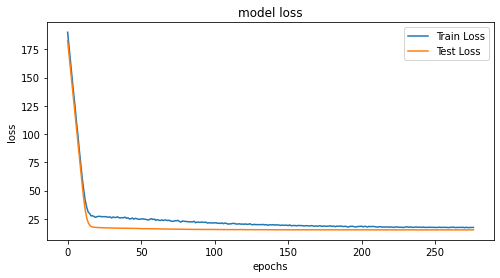

In [117]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [89]:
import seaborn as sns

In [118]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2616,2896)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

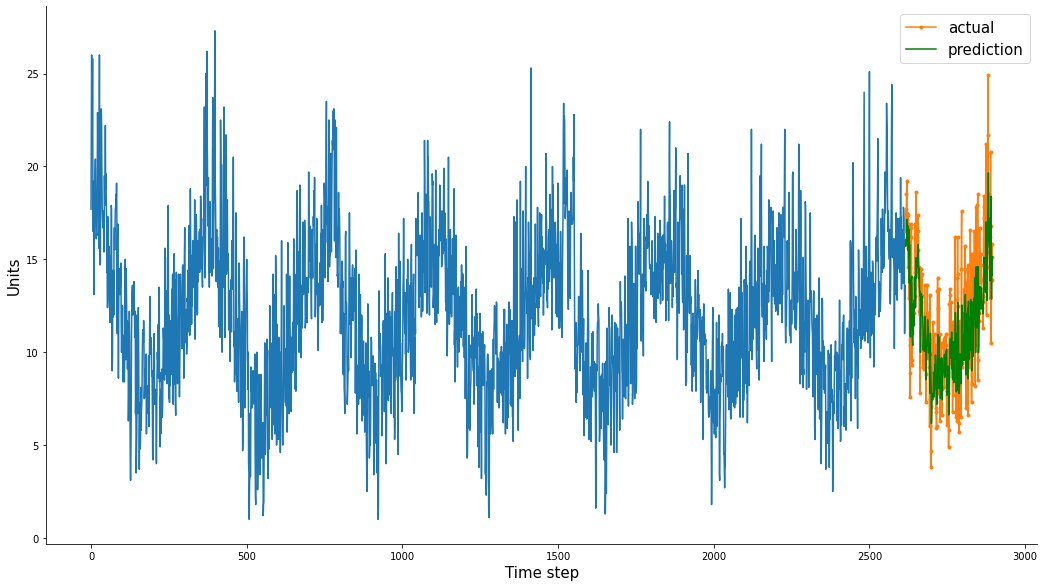

In [119]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)